# Download packages

In [ ]:
!pip install librosa

In [ ]:
!pip install h5py

In [ ]:
import os
import librosa
import numpy as np
import h5py
import tensorflow as tf
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
import IPython.display as ipd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# data exploration

In [ ]:
filename = '/content/drive/MyDrive/BA865_Group_3/dataset/Arabic/common_voice_ar_24081934.mp3'
audio, sr = librosa.load(filename, sr=None)

In [ ]:
# normalize
audio = librosa.util.normalize(audio)

In [ ]:
# remove leading and trailing silence
audio_trimmed, index = librosa.effects.trim(audio, top_db=30, frame_length=2048, hop_length=512)

Here, the code trims leading and trailing silence from the audio file. The top_db=30 parameter determines what counts as silence, and frame_length and hop_length define how precisely silence is detected. It also checks the length of the trimmed audio to see how much silence was removed.

In [ ]:
print(sr)

32000


In [ ]:
len(audio)

99072

In [ ]:
audio

array([ 0.0000000e+00,  9.0481816e-13,  8.5594872e-13, ...,
       -6.8197628e-06, -7.9974789e-06, -1.1364303e-05], dtype=float32)

In [ ]:
ipd.Audio(audio, rate=sr)

This line creates an interactive audio player that lets you play the loaded audio. The rate parameter specifies the playback sample rate, matching the original audio sample rate.

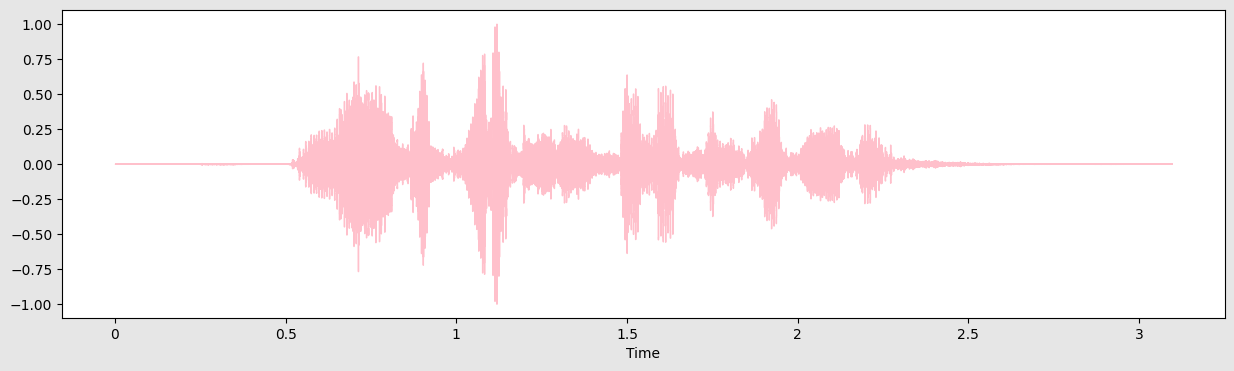

In [ ]:
plt.figure(figsize=(15,4), facecolor=(.9,.9,.9))
librosa.display.waveshow(audio, sr=sr, color='pink')

This section creates a plot to visualize the audio waveform. The figure size is set to 15 by 4, and the background is a light gray. The audio waveform is displayed in pink, showing how the amplitude varies over time.

In [ ]:
len(audio_trimmed)

61440

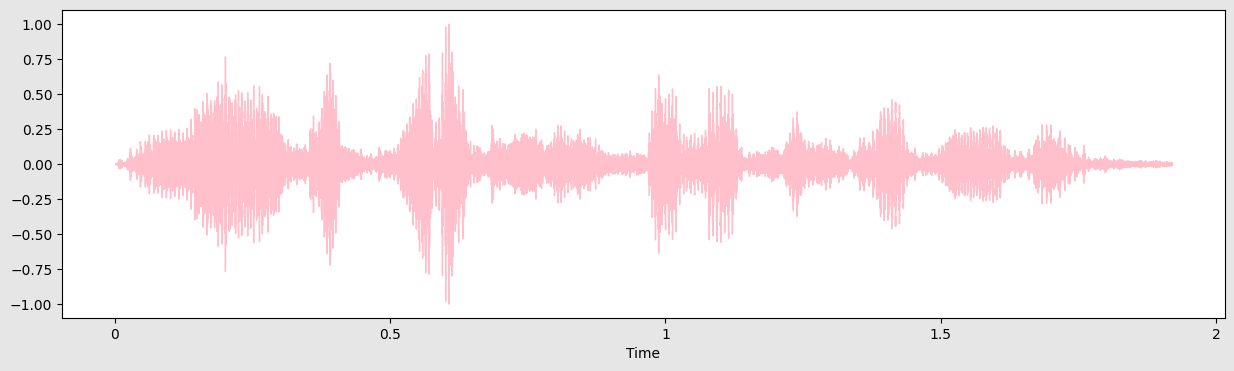

In [ ]:
plt.figure(figsize=(15,4), facecolor=(.9,.9,.9))
librosa.display.waveshow(audio_trimmed, sr=sr, color='pink')

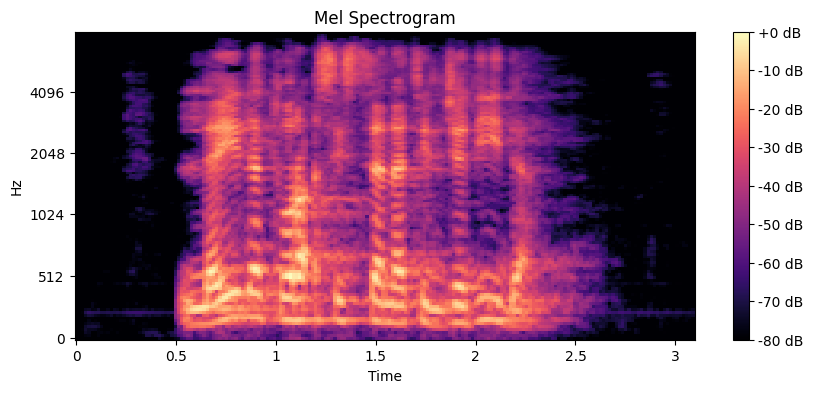

In [ ]:
# spectrogram

S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
S_DB = librosa.power_to_db(S, ref=np.max)

# plot Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

This code block creates a Mel spectrogram to visualize the frequency content of the audio. It uses 128 Mel bands and a maximum frequency of 8000 Hz. The spectrogram is converted to decibels for easier visualization. The plot displays the spectrogram with time on the x-axis and Mel frequency on the y-axis, adding a color bar to indicate decibel values.

In [ ]:
# MFCCs

mfccs = librosa.feature.mfcc(y=audio_trimmed, sr=sr, n_mfcc=13)
mfccs

array([[-493.3317   , -438.62198  , -402.25662  , ..., -413.2952   ,
        -424.00986  , -448.39624  ],
       [  95.46801  ,  114.301956 ,  131.03494  , ...,  126.91464  ,
         125.31235  ,  117.58565  ],
       [  49.322365 ,   25.253819 ,   14.687228 , ...,    8.358849 ,
          14.288259 ,   25.641647 ],
       ...,
       [  -3.7653837,   10.876099 ,   18.737736 , ...,  -15.624172 ,
         -16.996805 ,   -8.512718 ],
       [ -16.59674  ,  -16.952732 ,  -15.096426 , ...,    6.0562105,
           4.960675 ,   15.006832 ],
       [ -36.15443  ,  -47.326813 ,  -43.489944 , ...,    9.237858 ,
          12.424245 ,   17.81099  ]], dtype=float32)

This line calculates the MFCCs, which are key features used in audio and speech analysis. By using n_mfcc=13, we extract 13 coefficients from the trimmed audio, indicating the spectral properties in a way that can be useful for identifying patterns.

In [ ]:
# Spectral features

spectral_centroids = librosa.feature.spectral_centroid(y=audio_trimmed, sr=sr)
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_trimmed, sr=sr)
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_trimmed, sr=sr)
spectral_flatness = librosa.feature.spectral_flatness(y=audio_trimmed)

These lines calculate several spectral features. The spectral centroid represents the "center of mass" of the frequency spectrum. The spectral bandwidth shows the range of frequencies, while spectral rolloff points to the frequency at which a certain percentage of spectral energy is found. Spectral flatness indicates how noise-like the spectrum is.

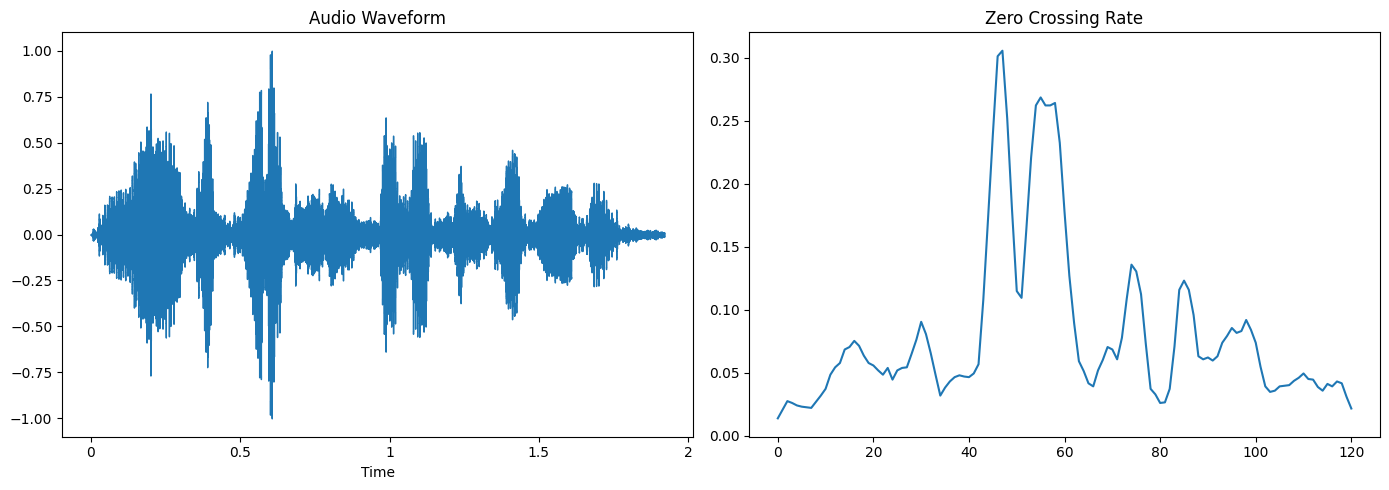

In [ ]:
# zero crossing rate
zcr = librosa.feature.zero_crossing_rate(audio_trimmed)[0]

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
librosa.display.waveshow(audio_trimmed, sr=sr)
plt.title('Audio Waveform')
plt.subplot(1, 2, 2)
plt.plot(zcr)
plt.title('Zero Crossing Rate')
plt.tight_layout()
plt.show()

The code calculates the zero crossing rate, which counts the number of times the audio waveform crosses the zero amplitude line. This can help identify high-frequency components in the audio. The plot creates a figure with two subplots: one for the audio waveform and one for the ZCR. It's a helpful visualization for understanding the audio's characteristics.

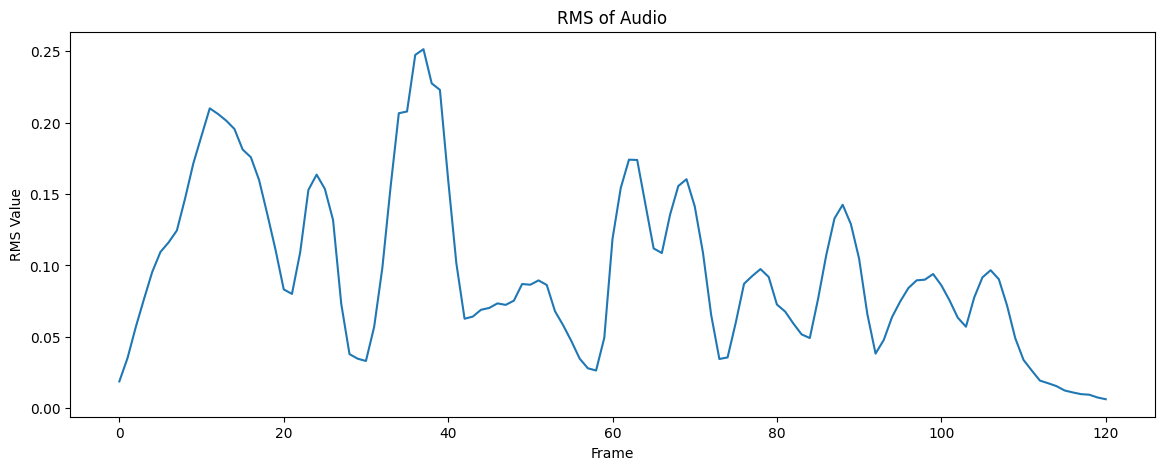

In [ ]:
# root mean square

rms_value = librosa.feature.rms(y=audio_trimmed)

plt.figure(figsize=(14, 5))
plt.plot(rms_value[0])
plt.title('RMS of Audio')
plt.xlabel('Frame')
plt.ylabel('RMS Value')
plt.show()

This snippet calculates the RMS value, a measure of the average energy or loudness of the audio. The plot displays the RMS over time, indicating how the energy level changes across frames. It helps to understand the intensity and dynamics of the audio.

In [ ]:
# overall rms
overall_rms = rms_value.mean()
print(overall_rms)

0.09651811


In [ ]:
# Chroma

chromagram = librosa.feature.chroma_stft(y=audio_trimmed, sr=sr)
chromagram

array([[0.6375936 , 0.2688517 , 0.5798342 , ..., 0.1373629 , 0.23141137,
        0.15912254],
       [0.5997216 , 0.23445512, 0.3547376 , ..., 0.20090078, 0.20399068,
        0.1913616 ],
       [0.6049858 , 0.33641392, 0.19677605, ..., 0.5906956 , 0.40953064,
        0.59062815],
       ...,
       [0.17827918, 0.1802443 , 0.12706847, ..., 0.01847074, 0.02453179,
        0.06386322],
       [0.35363486, 0.32485598, 0.11897898, ..., 0.04656111, 0.04662573,
        0.05874284],
       [0.58625793, 0.57411695, 0.46508878, ..., 0.06959466, 0.13575038,
        0.09973601]], dtype=float32)

This line generates a chromagram, which represents the intensity of pitch classes (like notes in music) in the audio. It's useful for analyzing musical content and understanding pitch-related patterns. The frame length and hop length define the resolution of the chromagram.

In [ ]:
# pitch

pitches, magnitudes = librosa.piptrack(y=audio_trimmed, sr=sr)

# Audio-to-text

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/BA865_Group_3/ba865-group-proj-3755f8eebd7a.json"

!pip install google-cloud-speech

Audio-to-text language codes:

Arabic: ar-EG

Chinese: zh-CN

English: en-US

French: fr-FR

Germany: de-DE

Japanese: ja-JP

Russian: ru-RU

Spanish: es-ES

Thai: th-TH

There may be many regional dialects for different languages, but we chose the one that is most common.

In [ ]:
# from google.cloud import speech
# import io
# import soundfile as sf

# client = speech.SpeechClient()
# with io.BytesIO() as audio_buffer:
#     sf.write(audio_buffer, audio_trimmed, sr, format='wav')
#     audio_bytes = audio_buffer.getvalue()

# audio_recon = speech.RecognitionAudio(content=audio_bytes)

# config = speech.RecognitionConfig(
#     encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
#     sample_rate_hertz=sr,
#     language_code='ar-EG',
#     enable_word_time_offsets=True
# )

# response = client.recognize(config=config, audio=audio_recon)
# total_words = 0
# total_duration = 0

# for result in response.results:
#     alternative = result.alternatives[0]
#     print('Transcript: {}'.format(alternative.transcript))
#     for word_info in alternative.words:
#         start_time = word_info.start_time.total_seconds()
#         end_time = word_info.end_time.total_seconds()
#         total_duration += end_time - start_time
#         total_words += 1

# speech_rate = (total_words / total_duration) * 60 if total_duration > 0 else 0
# print(f"Speech Rate: {speech_rate:.2f} words per minute (WPM)")

Transcript: ليله راس السنه الجديد
Speech Rate: 133.33 words per minute (WPM)


These code snippets provide a method to convert audio to text, which we converted into Arabic. However, due to errors in speech conversion, this set of code was discarded.

# Batch preprocessing

In [ ]:
# language_codes = {
#     "Arabic": "ar-EG",
#     "Chinese": "zh-CN",
#     "English": "en-US",
#     "French": "fr-FR",
#     "Germany": "de-DE",
#     "Japanese": "ja-JP",
#     "Russian": "ru-RU",
#     "Spanish": "es-ES",
#     "Thai": "th-TH"
# }

# def get_language_code(file_path):
#     # Extract the folder name from the file path
#     folder_name = os.path.basename(os.path.dirname(file_path))
#     # Return the corresponding language code
#     return language_codes.get(folder_name, "en-US")  # Default to English if not found

In [ ]:
# client = speech.SpeechClient()

# def process_audio(file_path):
#     try:
#         audio, sr = librosa.load(file_path, sr=None)
#         audio = librosa.util.normalize(audio)
#         audio_trimmed, _ = librosa.effects.trim(audio, top_db=30, frame_length=2048, hop_length=512)

#         # feature Extraction
#         S = librosa.feature.melspectrogram(y=audio_trimmed, sr=sr, n_mels=128, fmax=8000)
#         S_DB = librosa.power_to_db(S, ref=np.max)
#         mfccs = librosa.feature.mfcc(y=audio_trimmed, sr=sr, n_mfcc=13)
#         chroma = librosa.feature.chroma_stft(y=audio_trimmed, sr=sr)
#         pitches, magnitudes = librosa.piptrack(y=audio_trimmed, sr=sr)
#         spectral_centroids = librosa.feature.spectral_centroid(y=audio_trimmed, sr=sr)
#         spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_trimmed, sr=sr)
#         spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_trimmed, sr=sr)
#         spectral_flatness = librosa.feature.spectral_flatness(y=audio_trimmed)
#         rms = librosa.feature.rms(y=audio_trimmed)
#         rms_avg = rms.mean()
#         zcr = librosa.feature.zero_crossing_rate(audio_trimmed)[0]

#         # audio to text
#         with io.BytesIO() as audio_buffer:
#             sf.write(audio_buffer, audio_trimmed, sr, format='wav')
#             audio_bytes = audio_buffer.getvalue()
#         audio_recognition = speech.RecognitionAudio(content=audio_bytes)
#         config = speech.RecognitionConfig(
#             encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
#             sample_rate_hertz=sr,
#             language_code=get_language_code(file_path)
#         )
#         response = client.recognize(config=config, audio=audio_recognition)
#         transcript = ""
#         if response.results:
#             transcript = response.results[0].alternatives[0].transcript

#         features = {
#             'mfccs': mfccs,
#             'chroma': chroma,
#             'spectral_centroids': spectral_centroids,
#             'spectral_bandwidth': spectral_bandwidth,
#             'spectral_rolloff': spectral_rolloff,
#             'spectral_flatness': spectral_flatness,
#             'rms': rms,
#             'rms_avg': rms_avg,
#             'S': S,
#             'S_DB': S_DB,
#             'zcr': zcr
#         }
#         return features, transcript

#     except Exception as e:
#         print(f"Failed to process {file_path}: {str(e)}")
#         return {}, ""

# def batch_audio_processor(base_path):
#     transcripts = {}
#     for language in os.listdir(base_path):
#         lang_path = os.path.join(base_path, language)
#         if os.path.isdir(lang_path):
#             for audio_file in os.listdir(lang_path):
#                 if audio_file.endswith('.mp3'):
#                     file_path = os.path.join(lang_path, audio_file)
#                     print(f"Processing {file_path}...")
#                     features, transcript = process_audio(file_path)
#                     save_features(features, os.path.join(lang_path, f'{audio_file}.h5'))
#                     transcripts[os.path.basename(file_path)] = transcript
#     save_transcripts(transcripts, os.path.join(base_path, 'transcripts.csv'))


# def save_features(features, file_path):
#     with h5py.File(file_path, 'w') as h5f:
#         for key, data in features.items():
#             if isinstance(data, np.ndarray):
#                 h5f.create_dataset(key, data=data)
#             else:
#                 h5f.attrs[key] = data


# def save_transcripts(transcripts, csv_filename):
#     with open(csv_filename, 'w', newline='', encoding='utf-8') as file:
#         writer = csv.writer(file)
#         writer.writerow(['filename', 'transcript'])
#         for filename, transcript in transcripts.items():
#             writer.writerow([filename, transcript])


# base_path = '/content/drive/My Drive/BA865_Group_3/dataset'
# batch_audio_processor(base_path)

In [ ]:
def process_audio(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        audio = librosa.util.normalize(audio)
        audio_trimmed, _ = librosa.effects.trim(audio, top_db=30, frame_length=2048, hop_length=512)

        mfccs = librosa.feature.mfcc(y=audio_trimmed, sr=sr, n_mfcc=13)

        max_len = max(mfccs.shape[1], 873)
        padded_mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')

        mfccs_tensor = tf.convert_to_tensor(padded_mfccs, dtype=tf.float32)

        label = os.path.basename(file_path)

        return {'mfccs': mfccs_tensor, 'label': label}

    except Exception as e:
        print(f"Failed to process {file_path}: {str(e)}")
        return {}

def process_audio_parallel(file_paths):
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_audio, file_paths))
    return results

def batch_audio_processor(base_path, output_file):
    file_paths = []
    labels = []
    for language in os.listdir(base_path):
        lang_path = os.path.join(base_path, language)
        if os.path.isdir(lang_path):
            for audio_file in os.listdir(lang_path):
                if audio_file.endswith('.mp3'):
                    file_paths.append(os.path.join(lang_path, audio_file))
                    labels.append(language)
    results = process_audio_parallel(file_paths)

    max_len = max(result['mfccs'].shape[1] for result in results if 'mfccs' in result)

    mfccs_list = []
    for result in results:
        if 'mfccs' in result:
            mfccs = result['mfccs']
            padded_mfccs = tf.pad(mfccs, [[0, 0], [0, max_len - mfccs.shape[1]]])
            mfccs_list.append(padded_mfccs)

    stacked_mfccs = tf.stack(mfccs_list)

    with h5py.File(output_file, 'w') as h5f:
        h5f.create_dataset('mfccs', data=stacked_mfccs.numpy())
        h5f.create_dataset('labels', data=labels)

base_path = '/content/drive/MyDrive/BA865_Group_3/dataset'
output_file = '/content/drive/MyDrive/BA865_Group_3/dataset/mfccs_and_labels_test.h5'
batch_audio_processor(base_path, output_file)

This code is used to process multiple audio files, extract MFCCs, and store them in an HDF5 file for further analysis or model training. It can use parallel processing to speed up the task and ensure consistent formatting for the generated features and labels.

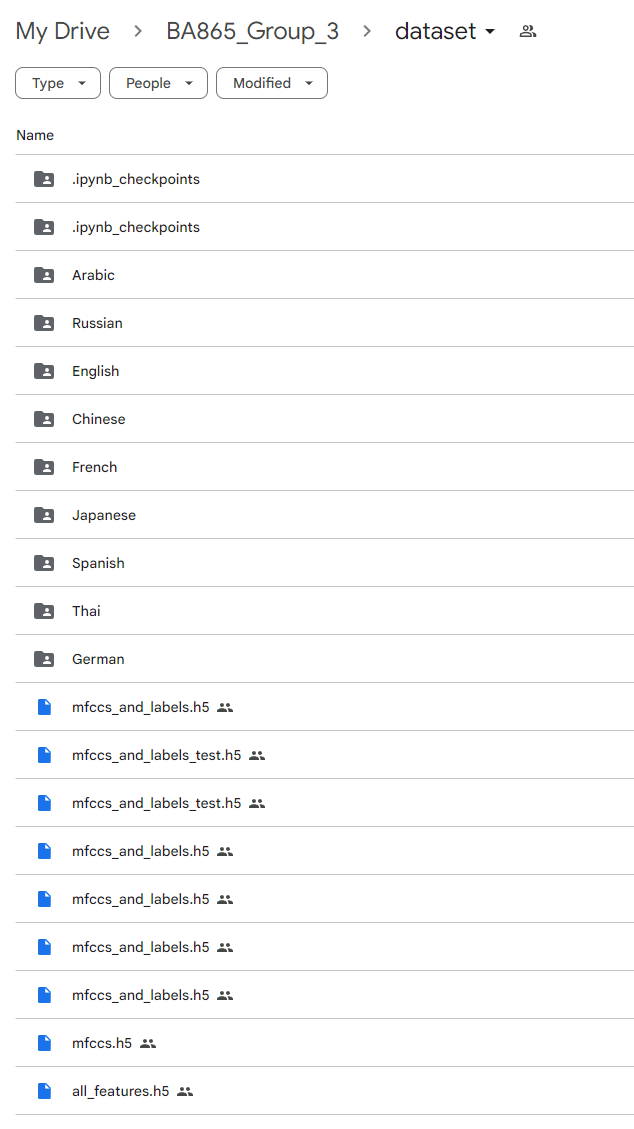

In [ ]:
import pandas as pd
transcript = pd.read_csv('/content/drive/MyDrive/BA865_Group_3/transcripts.csv')
transcript.head(10)

,filename,transcript
0,common_voice_ja_36372133.mp3,動物の好意的 直感的とか 概念的とかいうのは 言い過ぎと言われるでもあろう
1,common_voice_ja_36372141.mp3,それは人間の社会的構造とは異なったもの
2,common_voice_ja_36372143.mp3,を取り立てて素晴らしいわけではないが満足
3,common_voice_ja_36372171.mp3,ハグして いつもそうするん
4,common_voice_ja_36372159.mp3,それ以上の理由はない
5,common_voice_ja_36372165.mp3,憶測が憶測を
6,common_voice_ja_36372158.mp3,必要なパソコンを買う金を工面する
7,common_voice_ja_36372168.mp3,オレゴン州の災害都市は ポートランド
8,common_voice_ja_36372163.mp3,ミシンだけどむしろ足を引っ張って
9,common_voice_ja_36372149.mp3,真に 古物 相互限定の世界は ライプニッツのモナドの世界の如きもの でなければなら


In [ ]:
transcript.shape

(900, 2)

# References

1. https://www.youtube.com/watch?v=vbhlEMcb7RQ
2. https://medium.com/@karthikmandapaka/handling-audio-data-for-machine-learning-7ba225f183cb
3. https://cloud.google.com/speech-to-text/docs/transcribe-api?_gl=1*e6i4h4*_ga*NjczNjg1ODQzLjE3MTI5NzcxNTA.*_ga_WH2QY8WWF5*MTcxMjk3NzE1MC4xLjEuMTcxMjk3OTk5MC4wLjAuMA..&_ga=2.30888056.-673685843.1712977150
4. https://codelabs.developers.google.com/codelabs/cloud-speech-text-python3#0
5. https://cloud.google.com/speech-to-text/docs/reference/rest